C:\Users\Lenovo\Contacts
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  
Filename: 10554236.pdf
Content: ACCOUNTANT
Summary
Financial Accountant specializing in financial planning, reporting and analysis within the Department of Defense.
Highlights
Account reconcilia

<Figure size 720x432 with 0 Axes>

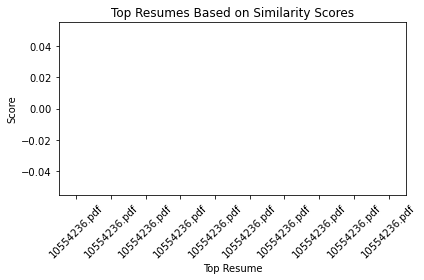

Aap apne resume ko kitna relevant maante hain? (1-10 scale): 7
Kya aapko kisi specific area me madad chahiye? yes4
Model saved as 'resume_ranking_model.pkl'
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Lenovo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# Install required libraries (run separately in your environment)
# !pip install spacy scikit-learn pandas PyPDF2 Flask nltk

#-------------------------------------------------------------------------------------------------------------------------------
import os
import pandas as pd
from PyPDF2 import PdfReader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import matplotlib.pyplot as plt
from flask import Flask, request, render_template, jsonify
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#-------------------------------------------------------------------------------------------------------------------------------
# Print current working directory
print(os.getcwd())

#-------------------------------------------------------------------------------------------------------------------------------
# Load job descriptions using pd.read_excel (corrected from pd.read_csv)
job_descriptions = pd.read_csv('sample_resumes/Resume/job_descriptions.xlsx.csv')

# Display the first few rows of the DataFrame to check the content
print(job_descriptions.head())

#-------------------------------------------------------------------------------------------------------------------------------
# Function to read PDF files
def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text()
    return text

# Path to the accountant resumes folder
accountant_folder_path = 'sample_resumes/data/data/accountant/'

# Read all resumes in the accountant folder
accountant_resumes = {}
for filename in os.listdir(accountant_folder_path):
    if filename.endswith('.pdf'):  # Assuming resumes are in PDF format
        resume_text = read_pdf(os.path.join(accountant_folder_path, filename))
        accountant_resumes[filename] = resume_text

# Display the first few loaded resumes
for name, content in list(accountant_resumes.items())[:3]:  # Display first 3 resumes
    print(f"Filename: {name}")
    print(f"Content: {content[:200]}...")  # Displaying first 200 characters of each resume
    print()

#-------------------------------------------------------------------------------------------------------------------------------
# Check the types of job descriptions
print(job_descriptions.dtypes)
print(job_descriptions.head())

# Check if resume texts are all strings
print(all(isinstance(text, str) for text in resume_texts))

# Convert job descriptions and resume texts to strings
job_description_texts = job_descriptions.iloc[:, 0].astype(str).tolist()
resume_texts = [str(resume) for resume in accountant_resumes.values()]

#-------------------------------------------------------------------------------------------------------------------------------
# Create a TF-IDF Vectorizer and fit the model
tfidf_vectorizer = TfidfVectorizer()
all_texts = job_description_texts + resume_texts
tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix[:len(job_description_texts)], tfidf_matrix[len(job_description_texts):])

# Convert similarity matrix to DataFrame for better visualization
similarity_df = pd.DataFrame(cosine_sim, columns=list(accountant_resumes.keys()), index=job_description_texts)

# Get the top resume for each job description
top_resumes = similarity_df.idxmax(axis=1)  # Get the filename of the top resume
top_scores = similarity_df.max(axis=1)  # Get the maximum similarity score

# Combine results into a DataFrame
results_df = pd.DataFrame({'Job Description': similarity_df.index, 'Top Resume': top_resumes, 'Score': top_scores})

# Display the results
print(results_df)

# Save results to a CSV file
results_df.to_csv('resume_ranking_results.csv', index=False)
print("Results saved to 'resume_ranking_results.csv'")

#-------------------------------------------------------------------------------------------------------------------------------
# Plotting top resumes
plt.figure(figsize=(10, 6))
results_df.sort_values(by='Score', ascending=False).head(10).plot(kind='bar', x='Top Resume', y='Score', legend=False)
plt.title('Top Resumes Based on Similarity Scores')
plt.xlabel('Top Resume')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------
# Function to collect feedback (can be used for collecting feedback from users)
def collect_feedback():
    relevance = input("Aap apne resume ko kitna relevant maante hain? (1-10 scale): ")
    improvement_area = input("Kya aapko kisi specific area me madad chahiye? ")
    feedback = {'relevance': relevance, 'improvement_area': improvement_area}
    return feedback

#-------------------------------------------------------------------------------------------------------------------------------
# Save feedback to a CSV
def save_feedback(feedback):
    feedback_df = pd.DataFrame([feedback])
    feedback_df.to_csv('feedback.csv', mode='a', header=False, index=False)

feedback = collect_feedback()
save_feedback(feedback)

#-------------------------------------------------------------------------------------------------------------------------------
# Train and save a model
X_train = ["Resume text 1", "Resume text 2", "Resume text 3"]  # Replace with actual data
y_train = [1, 0, 1]  # Replace with actual labels

model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
model.fit(X_train, y_train)

joblib.dump(model, 'resume_ranking_model.pkl')
print("Model saved as 'resume_ranking_model.pkl'")

#-------------------------------------------------------------------------------------------------------------------------------
# Flask App for prediction and feedback collection
app = Flask(__name__)

# Load the model
model = joblib.load('resume_ranking_model.pkl')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    new_resume = data['resume']
    predicted_relevance = model.predict([new_resume])
    return jsonify({'relevance': int(predicted_relevance[0])})

if __name__ == '__main__':
    app.run(debug=True)

#-------------------------------------------------------------------------------------------------------------------------------
